Average usage on non-charging days is 8 (kWh)
Baseline usage should be 2.76 kWh
Actual usage was 1.64 kWh
Which means that you consumed 1.12 kWh of solar on this day


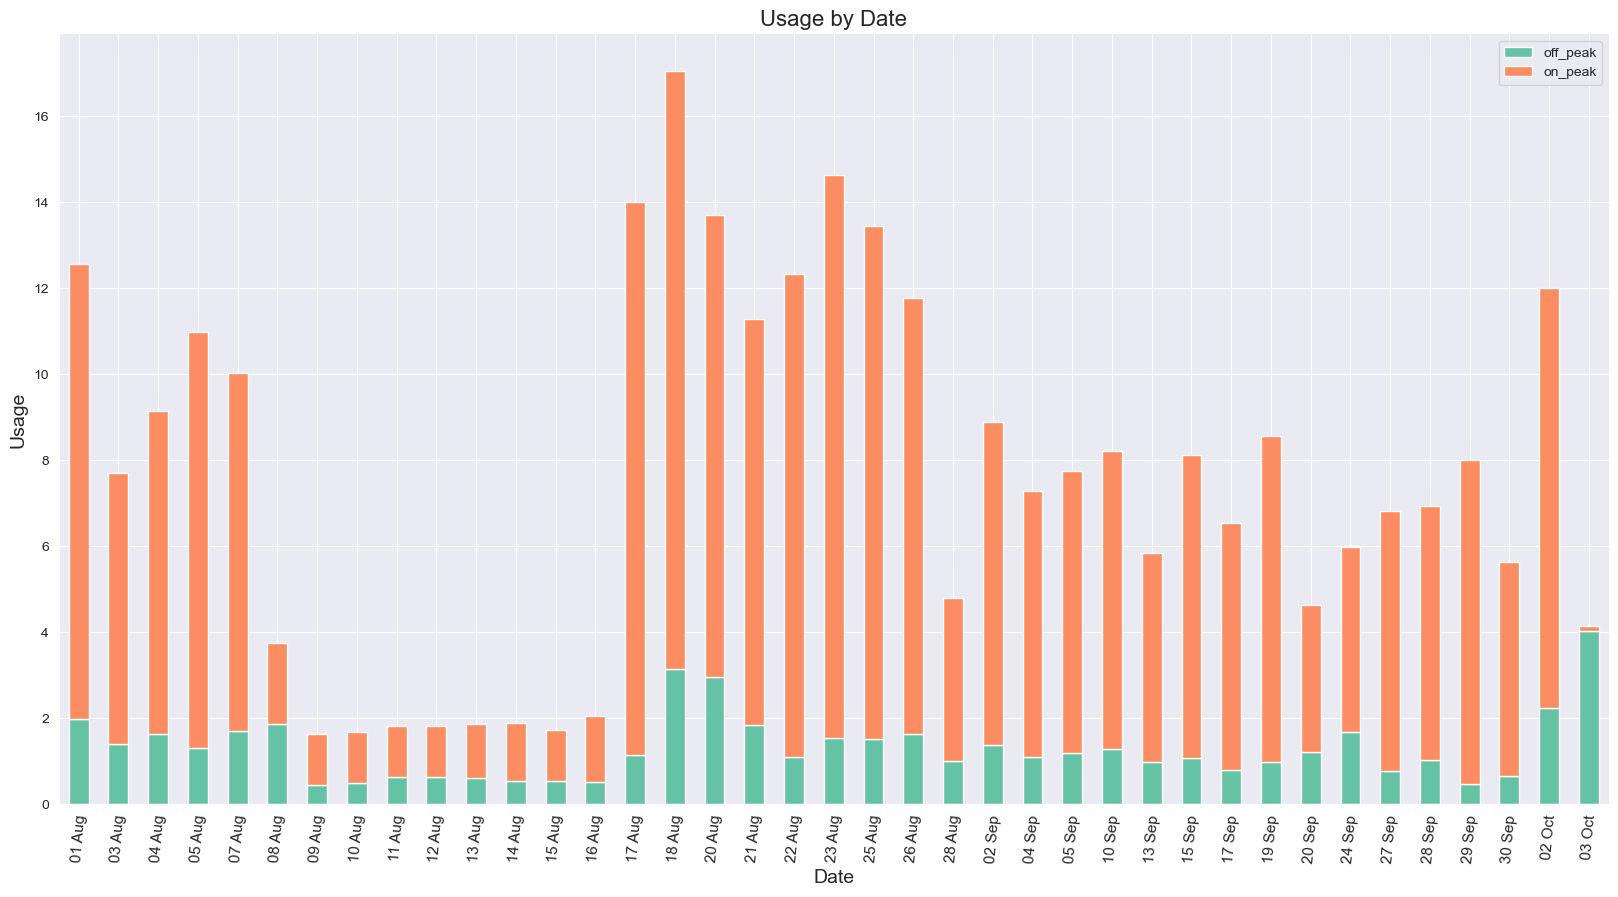

In [75]:
%matplotlib inline
 
import pandas as pd
import datetime
import numpy as np
 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as dates
 
df = pd.read_csv('consumption.csv'
                 ,header=0
                 ,names=['usage','tstamp']
                 ,usecols=['usage','tstamp']
                 ,parse_dates=['tstamp']
                 ,skiprows=1
                )
 
is_off_peak = (datetime.time(0,30) <= df.tstamp.dt.time) & (df.tstamp.dt.time <= datetime.time(4,30))
   
conditions = [is_off_peak, ~is_off_peak]
labels = ['off-peak', 'on-peak']
 
df['period'] = np.select(conditions, labels)
 
df_tstamp_index = df.set_index('tstamp')
off_peak = df_tstamp_index.between_time('0:30','4:30')
on_peak = df_tstamp_index.between_time('4:31','0:29')
 
 
off_peak = off_peak.resample('D').sum()
on_peak = on_peak.resample('D').sum()
 
off_peak.rename(columns={'usage':'off_peak'}, inplace=True)
on_peak.rename(columns={'usage':'on_peak'}, inplace=True)
 
usage_df = pd.concat([off_peak, on_peak], axis=1)
usage_df['usage'] = usage_df.off_peak + usage_df.on_peak
usage_df['percent_off_peak'] = (usage_df.off_peak * 100 / usage_df.usage).round().astype(int)
 
sns.set_style('darkgrid')
sns.set_palette('Set2')
 
non_charging_days = usage_df.query('usage < 20')
ax = non_charging_days.plot(kind='bar', stacked=True, y=['off_peak','on_peak'], figsize=(20,10))
#ax = usage_df.plot(kind='bar', stacked=True, y=['off_peak','on_peak'], figsize=(20,10))

ax.set_xticklabels(non_charging_days.index.strftime("%d %b"))
plt.gca().xaxis.set_major_locator(dates.DayLocator(interval=1))
 
plt.title('Usage by Date', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Usage', fontsize=14)
plt.xticks(rotation=85, fontsize=11)
sns.despine()
plt.plot()

print("Average usage on non-charging days is %s (kWh)" % round(non_charging_days['usage'].mean()))
calculated = round(usage_df.loc['2022-08-09']['off_peak']*24/4,2)
actual = round(usage_df.loc['2022-08-09']['usage'],2)
print("Baseline usage should be %s kWh" % calculated)
print("Actual usage was %s kWh" % actual)
print("Which means that you consumed %s kWh of solar on this day" % round((calculated - actual),2))
